## Task 2: Develop Time Series Forecasting Models

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the data
tsla = pd.read_csv('../data/TSLA_cleaned.csv', index_col='Date', parse_dates=True)
bnd = pd.read_csv('../data/BND_cleaned.csv', index_col='Date', parse_dates=True)
spy= pd.read_csv('../data/SPY_cleaned.csv', index_col='Date', parse_dates=True)

# Ensure 'Adj Close' is available and drop NaNs if needed
tsla['Adj Close'] = pd.to_numeric(tsla['Adj Close'], errors='coerce')
tsla = tsla.dropna(subset=['Adj Close'])

# Ensure 'Adj Close' is available and drop NaNs if needed
bnd['Adj Close'] = pd.to_numeric(bnd['Adj Close'], errors='coerce')
bnd = bnd.dropna(subset=['Adj Close'])

spy['Adj Close'] = pd.to_numeric(spy['Adj Close'], errors='coerce')
spy = spy.dropna(subset=['Adj Close'])

# Split the data (e.g., 80% training, 20% testing)
train_size = int(len(tsla) * 0.8)
train, test = tsla['Adj Close'][:train_size], tsla['Adj Close'][train_size:]


In [2]:
tsla.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2474 entries, 2015-01-02 00:00:00+00:00 to 2024-10-30 00:00:00+00:00
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2474 non-null   float64
 1   High       2474 non-null   float64
 2   Low        2474 non-null   float64
 3   Close      2474 non-null   float64
 4   Volume     2474 non-null   float64
 5   Adj Close  2474 non-null   float64
dtypes: float64(6)
memory usage: 135.3 KB


In [3]:
tsla.head()

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2015-01-02 00:00:00+00:00,14.858000,14.883333,14.217333,14.620667,71466000.0,14.620667
2015-01-05 00:00:00+00:00,14.303333,14.433333,13.810667,14.006000,80527500.0,14.006000
2015-01-06 00:00:00+00:00,14.004000,14.280000,13.614000,14.085333,93928500.0,14.085333
2015-01-07 00:00:00+00:00,14.223333,14.318667,13.985333,14.063333,44526000.0,14.063333
2015-01-08 00:00:00+00:00,14.187333,14.253333,14.000667,14.041333,51637500.0,14.041333


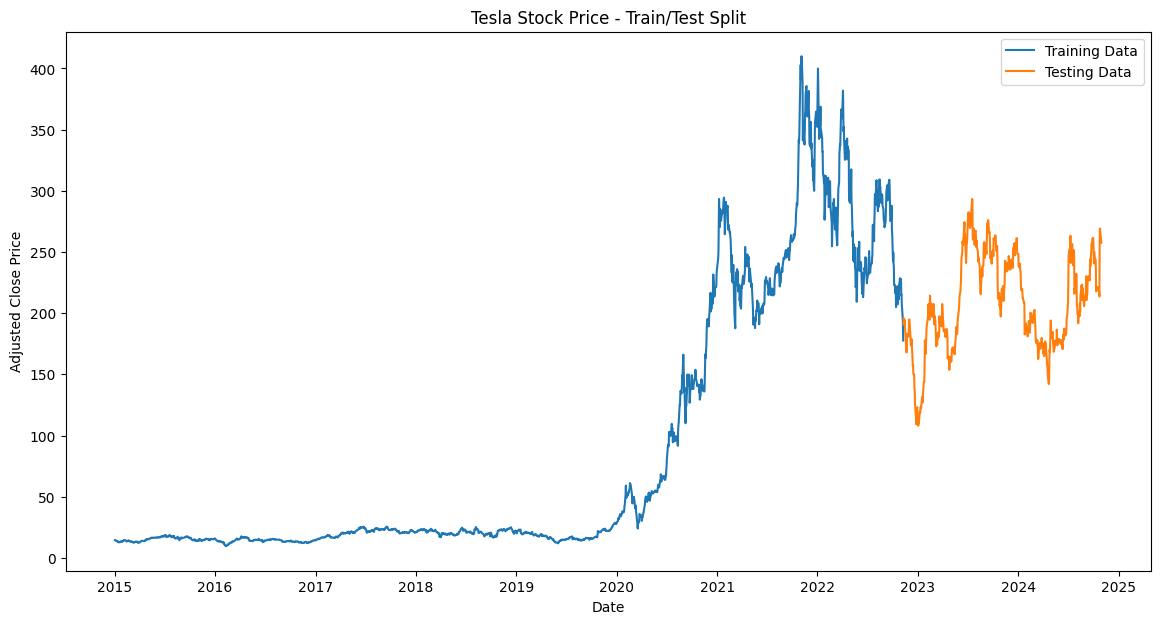

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(train, label='Training Data')
plt.plot(test, label='Testing Data')
plt.title('Tesla Stock Price - Train/Test Split')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()


In [5]:
from pmdarima import auto_arima

# Use auto_arima to search for a more complex model
model_auto_arima = auto_arima(train, seasonal=False, max_p=3, max_q=3, d=1, trace=True, stepwise=True)
print(model_auto_arima.summary())



Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=12345.046, Time=0.76 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12340.889, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12339.852, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12339.956, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12339.337, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=12341.053, Time=1.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.149 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1979
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -6168.668
Date:                Wed, 13 Nov 2024   AIC                          12339.337
Time:                        16:54:16   BIC                          12344.927
Sample:                             0   HQIC                         12341.391
    

### Assign a Frequency to the Date Index

In [6]:
# Ensure the date index has a frequency
train = train.asfreq('B')  # 'B' stands for business days
test = test.asfreq('B')

# Check if the frequency is set
print(train.index.freq)


<BusinessDay>


In [7]:
from statsmodels.tsa.arima.model import ARIMA

# Extract the best parameters from auto_arima
p, d, q = model_auto_arima.order

# Fit the ARIMA model
arima_model = ARIMA(train, order=(p, d, q))
arima_model_fit = arima_model.fit()
print(arima_model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                 2049
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -6173.705
Date:                Wed, 13 Nov 2024   AIC                          12349.410
Time:                        16:54:17   BIC                          12355.034
Sample:                    01-02-2015   HQIC                         12351.472
                         - 11-09-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        29.3696      0.313     93.685      0.000      28.755      29.984
Ljung-Box (L1) (Q):                   3.47   Jarque-Bera (JB):             23036.98
Prob(Q):                              0.06   Pr

### Model Validation

#### Residual Analysis: Check if the residuals are white noise by plotting them and analyzing their autocorrelation function (ACF).

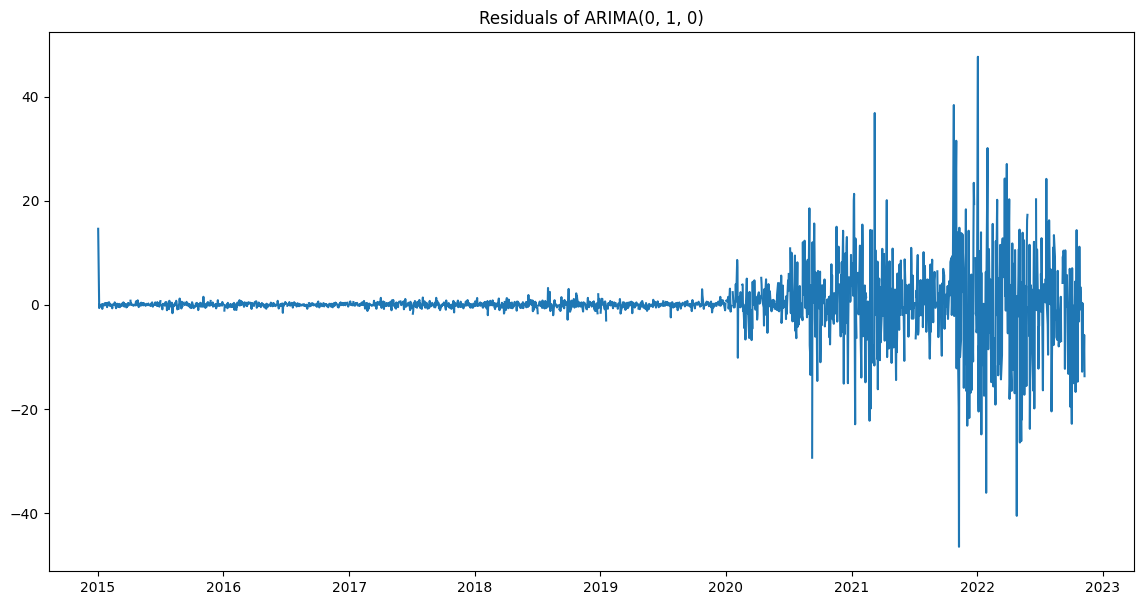

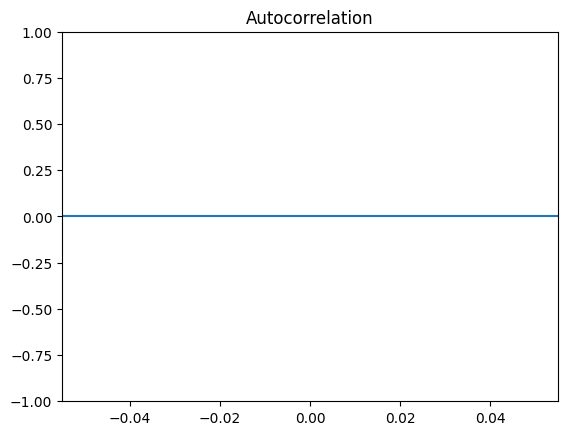

In [8]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Plot residuals
residuals = arima_model_fit.resid
plt.figure(figsize=(14, 7))
plt.plot(residuals)
plt.title('Residuals of ARIMA(0, 1, 0)')
plt.show()

# ACF plot of residuals
sm.graphics.tsa.plot_acf(residuals, lags=40)
plt.show()


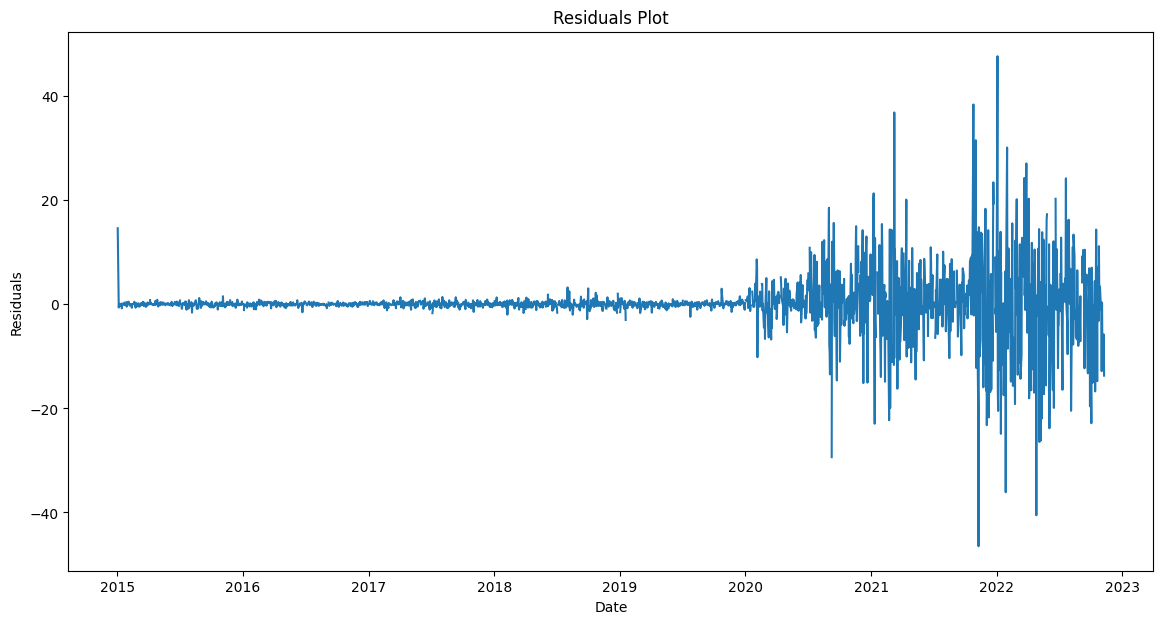

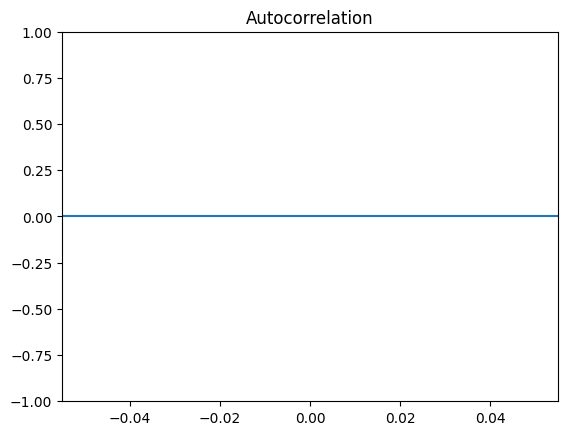

In [9]:
import statsmodels.api as sm
residuals = arima_model_fit.resid

# Plot residuals
plt.figure(figsize=(14, 7))
plt.plot(residuals)
plt.title('Residuals Plot')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.show()

# ACF of residuals
sm.graphics.tsa.plot_acf(residuals, lags=40)
plt.show()


#### Forecast Future Prices: Use the model to forecast future prices and compare with actual test data.

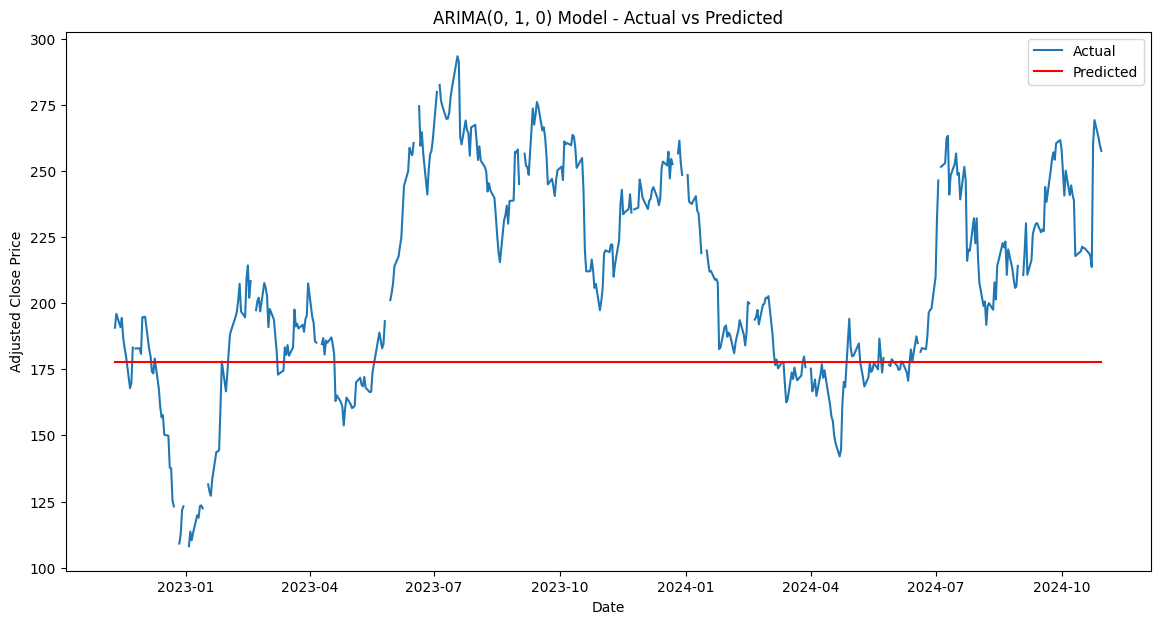

In [10]:
# Forecast future values
forecast_steps = len(test)  # Number of steps to forecast (size of test set)
predictions = arima_model_fit.forecast(steps=forecast_steps)

# Plot predictions vs actual values
plt.figure(figsize=(14, 7))
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, predictions, label='Predicted', color='red')
plt.title('ARIMA(0, 1, 0) Model - Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()


In [11]:
# Fill NaN values using forward fill or zero
test_clean = test.ffill()  # Use 'bfill()' or fillna(0) if preferred

# Ensure predictions align with filled 'test'
predictions_clean = predictions[test_clean.index]



In [12]:
import numpy as np
# Ensure the indices of test_clean and predictions_clean match
aligned_index = test_clean.index.intersection(predictions_clean.index)
test_clean = test_clean.loc[aligned_index]
predictions_clean = predictions_clean[aligned_index]

# Double-check for NaN values
print(f"Number of NaN values in aligned 'test': {test_clean.isnull().sum()}")
print(f"Number of NaN values in aligned 'predictions': {np.isnan(predictions_clean).sum()}")


Number of NaN values in aligned 'test': 0
Number of NaN values in aligned 'predictions': 0


In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(test_clean, predictions_clean)
rmse = np.sqrt(mean_squared_error(test_clean, predictions_clean))
mape = np.mean(np.abs((test_clean - predictions_clean) / test_clean)) * 100

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")


Mean Absolute Error (MAE): 39.06
Root Mean Squared Error (RMSE): 49.23
Mean Absolute Percentage Error (MAPE): 17.75%


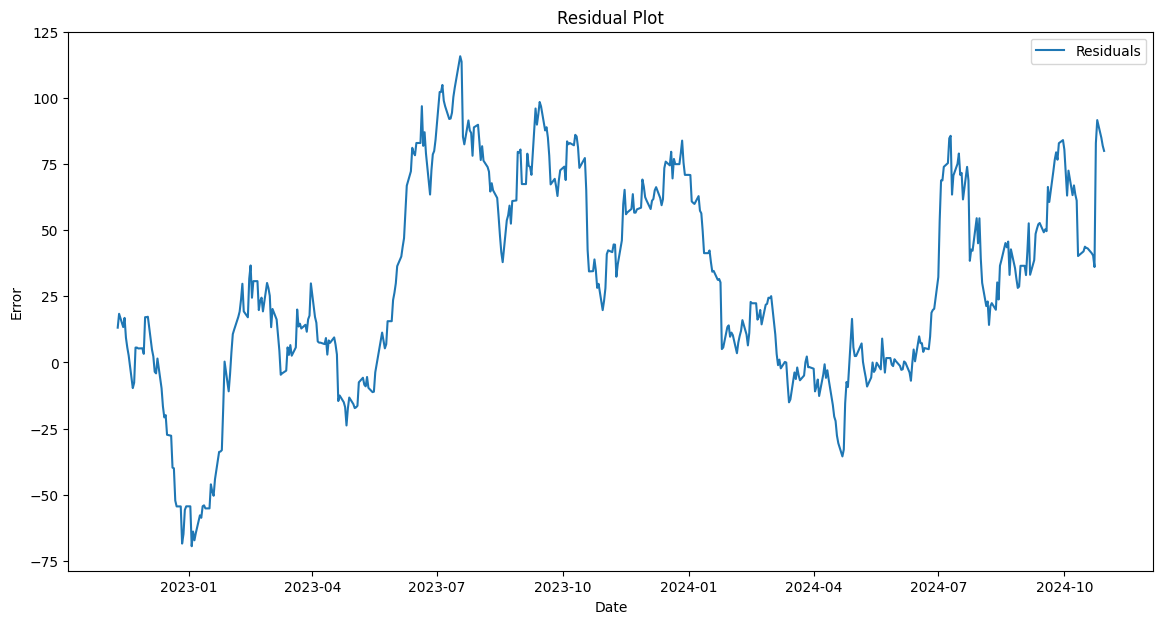

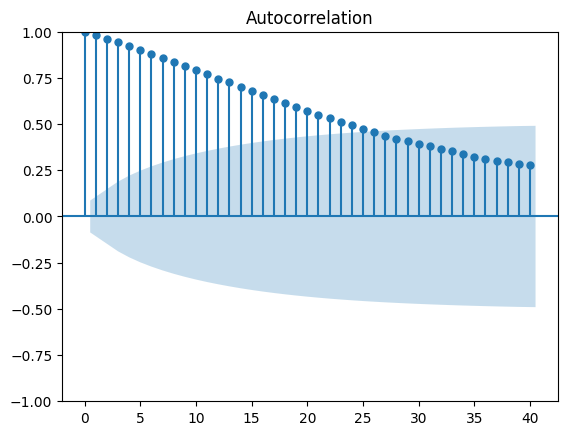

In [14]:
import matplotlib.pyplot as plt

residuals = test_clean - predictions_clean
plt.figure(figsize=(14, 7))
plt.plot(residuals, label='Residuals')
plt.title('Residual Plot')
plt.xlabel('Date')
plt.ylabel('Error')
plt.legend()
plt.show()

# Plot ACF of residuals to check for patterns
import statsmodels.api as sm
sm.graphics.tsa.plot_acf(residuals, lags=40)
plt.show()


### SARIMA Model


In [15]:
train = train.ffill()

In [16]:
from pmdarima import auto_arima

# Find best SARIMA parameters
model_auto_sarima = auto_arima(train, seasonal=True, m=30, trace=True, stepwise=True)
print(model_auto_sarima.summary())


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[30] intercept   : AIC=12685.878, Time=17.73 sec
 ARIMA(0,1,0)(0,0,0)[30] intercept   : AIC=12706.274, Time=0.13 sec
 ARIMA(1,1,0)(1,0,0)[30] intercept   : AIC=12706.662, Time=1.46 sec
 ARIMA(0,1,1)(0,0,1)[30] intercept   : AIC=12706.695, Time=1.76 sec
 ARIMA(0,1,0)(0,0,0)[30]             : AIC=12704.722, Time=0.11 sec
 ARIMA(2,1,2)(0,0,1)[30] intercept   : AIC=12683.898, Time=14.56 sec
 ARIMA(2,1,2)(0,0,0)[30] intercept   : AIC=12681.898, Time=5.12 sec
 ARIMA(2,1,2)(1,0,0)[30] intercept   : AIC=12683.897, Time=22.81 sec
 ARIMA(1,1,2)(0,0,0)[30] intercept   : AIC=12707.657, Time=1.64 sec
 ARIMA(2,1,1)(0,0,0)[30] intercept   : AIC=12708.790, Time=0.82 sec
 ARIMA(3,1,2)(0,0,0)[30] intercept   : AIC=12675.418, Time=3.42 sec
 ARIMA(3,1,2)(1,0,0)[30] intercept   : AIC=12677.418, Time=24.14 sec
 ARIMA(3,1,2)(0,0,1)[30] intercept   : AIC=12677.418, Time=24.07 sec
 ARIMA(3,1,2)(1,0,1)[30] intercept   : AIC=12679.412, Time=26.36 sec

In [17]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit SARIMA model using the best parameters
sarima_model = SARIMAX(train, order=model_auto_sarima.order, seasonal_order=model_auto_sarima.seasonal_order)
sarima_model_fit = sarima_model.fit(disp=False)
print(sarima_model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                 2049
Model:               SARIMAX(2, 1, 3)   Log Likelihood               -6330.919
Date:                Wed, 13 Nov 2024   AIC                          12673.837
Time:                        16:59:15   BIC                          12707.585
Sample:                    01-02-2015   HQIC                         12686.214
                         - 11-09-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3925      0.015    -91.492      0.000      -1.422      -1.363
ar.L2         -0.8683      0.016    -55.579      0.000      -0.899      -0.838
ma.L1          1.3657      0.018     76.218      0.0

### LSTM Model

In [18]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Scale data between 0 and 1
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train.values.reshape(-1, 1))

# Create LSTM input sequences
def create_sequences(data, sequence_length=60):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

sequence_length = 60
X_train, y_train = create_sequences(train_scaled, sequence_length)

# Reshape for LSTM input
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)


In [19]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=False, input_shape=(X_train.shape[1], 1)))
model.add(Dense(1))

# Compile and train the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=32)


c:\Users\zelalem.wubet\projects\personal\ten-academy\Portfolio-Optimization-TimeSeries\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 0.0353
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 8.5254e-04
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 8.8213e-04
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 8.6603e-04
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 7.0454e-04
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 8.2144e-04
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 5.9865e-04
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 6.2209e-04
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 5.6801e-04
Epoch 10/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 4.7916e-04
Epoch 11/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 4.8322e-04
Epoch 12/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 4.7212e-04
Epoch 13/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 4.2950e-04
Epoch 14/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 5.2699e-04
Epoch 15/50
63/63 ━

In [20]:
test = test.ffill() 

In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate MAE, RMSE, MAPE
mae = mean_absolute_error(test, predictions)
rmse = np.sqrt(mean_squared_error(test, predictions))
mape = np.mean(np.abs((test - predictions) / test)) * 100

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")


Mean Absolute Error (MAE): 39.06
Root Mean Squared Error (RMSE): 49.23
Mean Absolute Percentage Error (MAPE): 17.75%


## Task 3: Forecast Future Market Trends

### Forecast Future Values: Use the fitted ARIMA(2, 1, 3)

Forecasted Prices:
2022-11-10 00:00:00+00:00    177.589996
2022-11-11 00:00:00+00:00    177.589996
2022-11-14 00:00:00+00:00    177.589996
2022-11-15 00:00:00+00:00    177.589996
2022-11-16 00:00:00+00:00    177.589996
                                ...    
2023-10-23 00:00:00+00:00    177.589996
2023-10-24 00:00:00+00:00    177.589996
2023-10-25 00:00:00+00:00    177.589996
2023-10-26 00:00:00+00:00    177.589996
2023-10-27 00:00:00+00:00    177.589996
Freq: B, Name: predicted_mean, Length: 252, dtype: float64
2022-11-10: $177.59
2022-11-11: $177.59
2022-11-14: $177.59
2022-11-15: $177.59
2022-11-16: $177.59
2022-11-17: $177.59
2022-11-18: $177.59
2022-11-21: $177.59
2022-11-22: $177.59
2022-11-23: $177.59
2022-11-24: $177.59
2022-11-25: $177.59
2022-11-28: $177.59
2022-11-29: $177.59
2022-11-30: $177.59
2022-12-01: $177.59
2022-12-02: $177.59
2022-12-05: $177.59
2022-12-06: $177.59
2022-12-07: $177.59
2022-12-08: $177.59
2022-12-09: $177.59
2022-12-12: $177.59
2022-12-13: $177.59
20

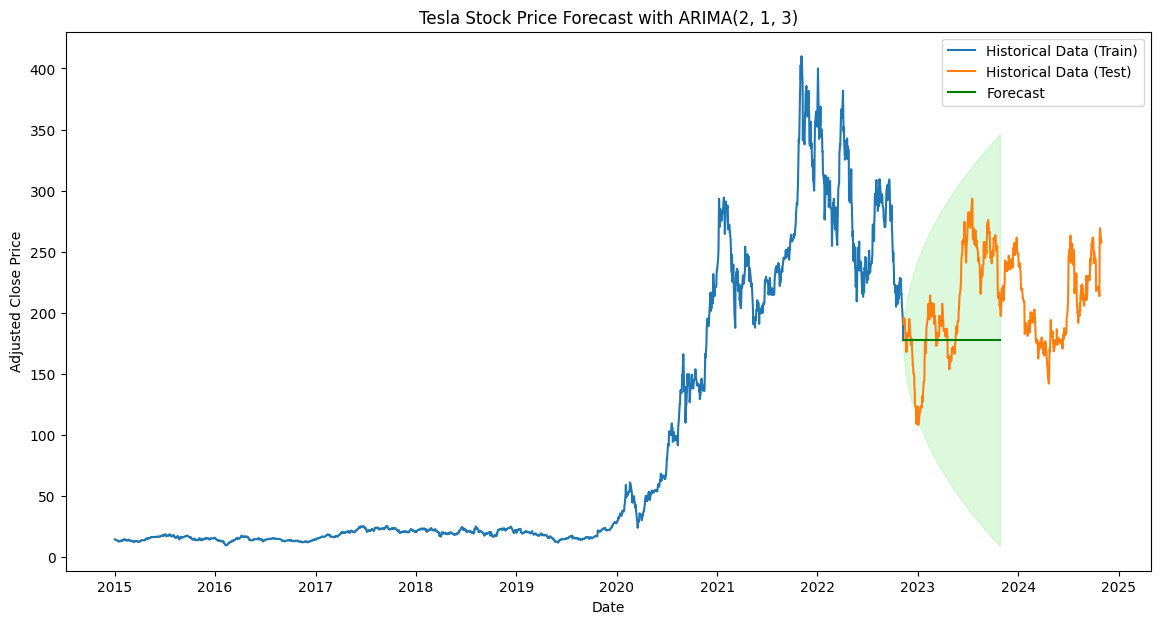

In [22]:
# Forecast for the next 6-12 months (e.g., 252 trading days)
forecast_steps = 252
forecast = arima_model_fit.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Print forecasted prices
print("Forecasted Prices:")
print(forecast_mean)

# Optionally print with dates and formatted output
for date, price in forecast_mean.items():
    print(f"{date.strftime('%Y-%m-%d')}: ${price:.2f}")

# Plot historical data and forecast
plt.figure(figsize=(14, 7))
plt.plot(train.index, train, label='Historical Data (Train)')
plt.plot(test.index, test, label='Historical Data (Test)')
plt.plot(forecast_mean.index, forecast_mean, label='Forecast', color='green')

# Plot confidence intervals
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1], color='lightgreen', alpha=0.3)

plt.title('Tesla Stock Price Forecast with ARIMA(2, 1, 3)')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()



#### Plot LSTM Forecasted Prices

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━

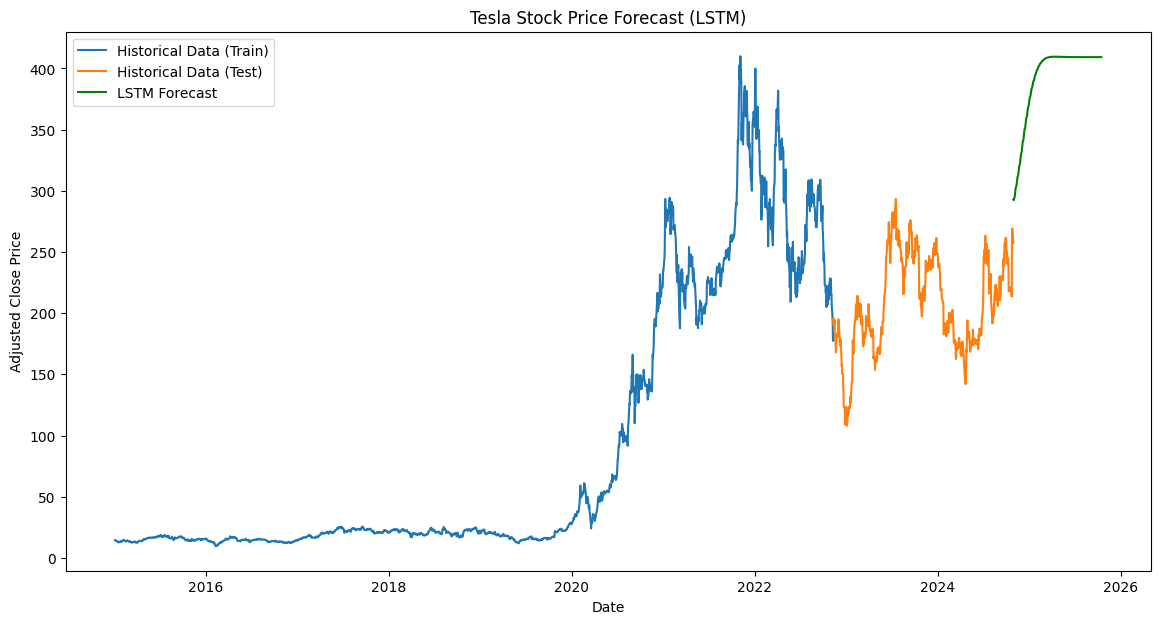

In [30]:
import pandas as pd

# Predict next steps using LSTM
last_sequence = train_scaled[-sequence_length:]  # Last input sequence for the LSTM
predictions = []

for _ in range(forecast_steps):
    pred = model.predict(last_sequence.reshape(1, sequence_length, 1))
    predictions.append(pred[0, 0])
    last_sequence = np.append(last_sequence[1:], pred, axis=0)

# Inverse transform the predictions to get actual price values
predictions_tsla_rescaled = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Create a date range for the forecasted values
forecast_dates = pd.date_range(test.index[-1], periods=forecast_steps, freq='B')

# Print forecasted prices with dates
print("LSTM Forecasted Prices:")
for date, price in zip(forecast_dates, predictions_tsla_rescaled):
    print(f"{date.strftime('%Y-%m-%d')}: ${price[0]:.2f}")

# Plot predictions with historical data
plt.figure(figsize=(14, 7))
plt.plot(train.index, train, label='Historical Data (Train)')
plt.plot(test.index, test, label='Historical Data (Test)')
plt.plot(forecast_dates, predictions_tsla_rescaled, label='LSTM Forecast', color='green')
plt.title('Tesla Stock Price Forecast (LSTM)')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()


## Data Preparation for BND and SPY

In [24]:
train_size_bnd = int(len(bnd) * 0.8)
train_bnd, test_bnd = bnd['Adj Close'][:train_size_bnd], bnd['Adj Close'][train_size_bnd:]

train_size_spy = int(len(spy) * 0.8)
train_spy, test_spy = spy['Adj Close'][:train_size_spy], spy['Adj Close'][train_size_spy:]

In [25]:
# Print the shapes of train and test sets for verification

print("BND - Train shape:", train_bnd.shape, "Test shape:", test_bnd.shape)
print("SPY - Train shape:", train_spy.shape, "Test shape:", test_spy.shape)

BND - Train shape: (1979,) Test shape: (495,)
SPY - Train shape: (1979,) Test shape: (495,)


In [26]:
# Scale and prepare data for BND
train_scaled_bnd = scaler.fit_transform(train_bnd.values.reshape(-1, 1))  # Assume train_bnd contains training data for BND

# Create LSTM input sequences for BND
X_train_bnd, y_train_bnd = create_sequences(train_scaled_bnd, sequence_length)
X_train_bnd = X_train_bnd.reshape(X_train_bnd.shape[0], X_train_bnd.shape[1], 1)  # Reshape for LSTM input

# Scale and prepare data for SPY
train_scaled_spy = scaler.fit_transform(train_spy.values.reshape(-1, 1))  # Assume train_spy contains training data for SPY

# Create LSTM input sequences for SPY
X_train_spy, y_train_spy = create_sequences(train_scaled_spy, sequence_length)
X_train_spy = X_train_spy.reshape(X_train_spy.shape[0], X_train_spy.shape[1], 1)  # Reshape for LSTM input


## Build and Train the LSTM Model for BND

In [27]:
# Build the LSTM model for BND
model_bnd = Sequential()
model_bnd.add(LSTM(units=50, return_sequences=False, input_shape=(X_train_bnd.shape[1], 1)))
model_bnd.add(Dense(1))

# Compile and train the model for BND
model_bnd.compile(optimizer='adam', loss='mean_squared_error')
model_bnd.fit(X_train_bnd, y_train_bnd, epochs=50, batch_size=32)


c:\Users\zelalem.wubet\projects\personal\ten-academy\Portfolio-Optimization-TimeSeries\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - loss: 0.0643
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0010
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 7.9244e-04
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 7.0954e-04
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 7.7637e-04
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 6.1872e-04
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 6.7654e-04
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 7.1455e-04
Epoch 9/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 6.4286e-04
Epoch 10/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 5.3497e-04
Epoch 11/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 6.9982e-04
Epoch 12/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 8.4981e-04
Epoch 13/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 5.0924e-04
Epoch 14/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 6.7354e-04
Epoch 15/50
60/60 ━━━━━

### Build and Train the LSTM Model for SPY

In [28]:
# Build the LSTM model for SPY
model_spy = Sequential()
model_spy.add(LSTM(units=50, return_sequences=False, input_shape=(X_train_spy.shape[1], 1)))
model_spy.add(Dense(1))

# Compile and train the model for SPY
model_spy.compile(optimizer='adam', loss='mean_squared_error')
model_spy.fit(X_train_spy, y_train_spy, epochs=50, batch_size=32)


Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 0.0543
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 6.0522e-04
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 5.1931e-04
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 4.7775e-04
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 4.8524e-04
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 4.3455e-04
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 4.5782e-04
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 4.4723e-04
Epoch 9/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 4.5416e-04
Epoch 10/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 4.4184e-04
Epoch 11/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 3.9414e-04
Epoch 12/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 4.7507e-04
Epoch 13/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 3.9760e-04
Epoch 14/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 3.7664e-04
Epoch 15/50
60/60 ━

## Make Future Predictions for BND and SPY

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━

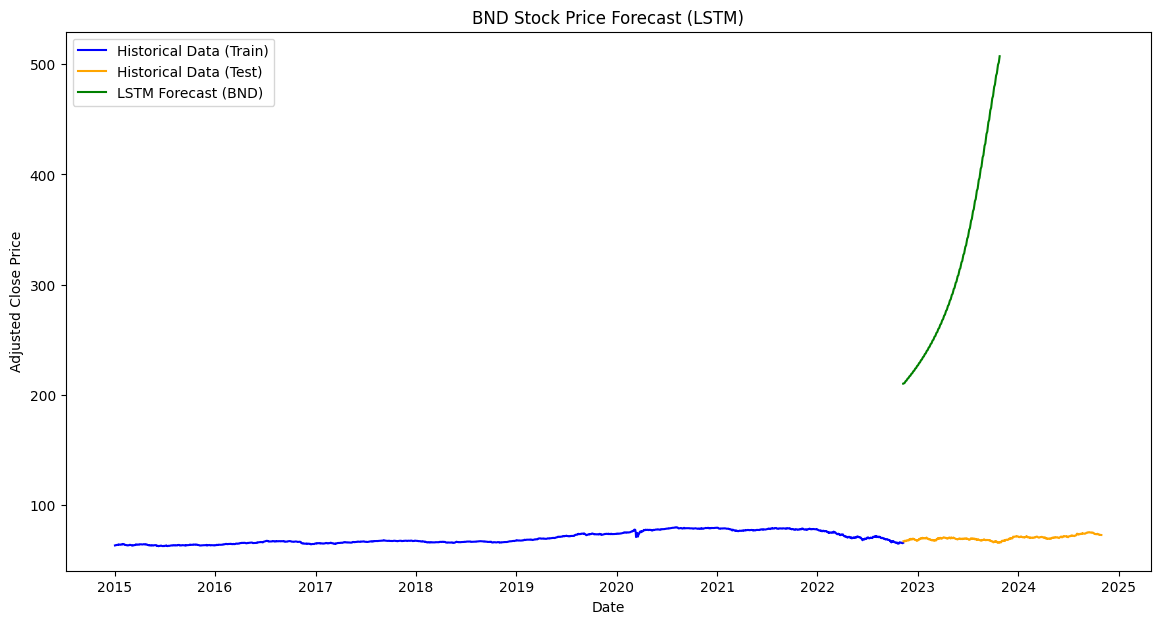

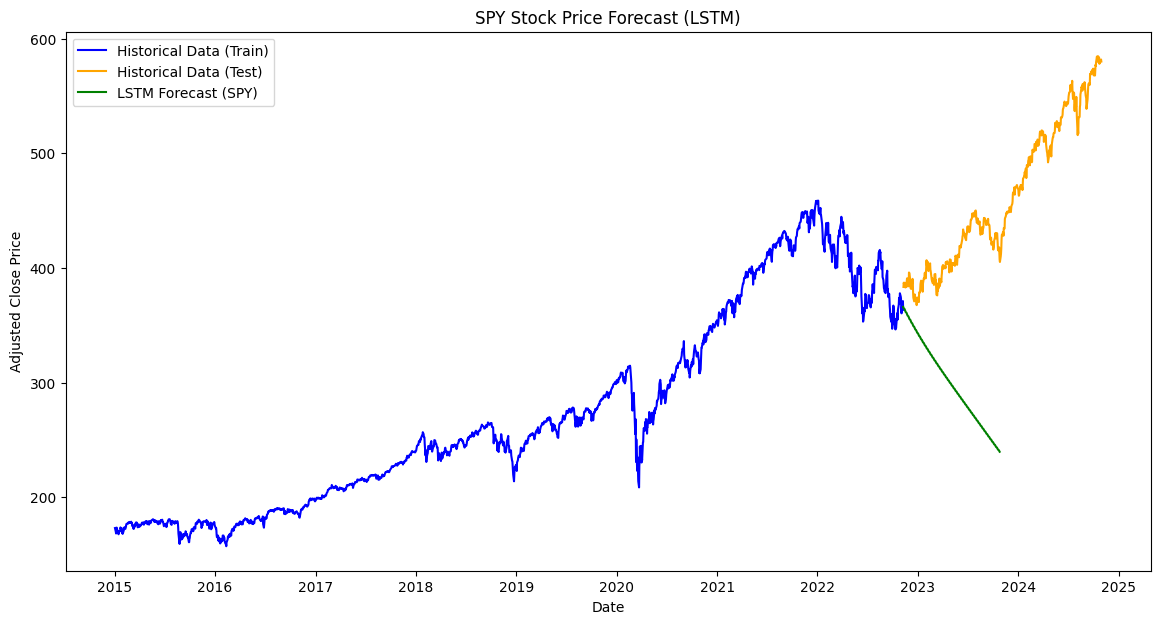

In [29]:
import matplotlib.pyplot as plt
import pandas as pd

# Predict future prices for BND and SPY (code as provided)
last_sequence_bnd = train_scaled_bnd[-sequence_length:]
predictions_bnd = []

for _ in range(forecast_steps):
    pred_bnd = model_bnd.predict(last_sequence_bnd.reshape(1, sequence_length, 1))
    predictions_bnd.append(pred_bnd[0, 0])
    last_sequence_bnd = np.append(last_sequence_bnd[1:], pred_bnd, axis=0)

predictions_bnd_rescaled = scaler.inverse_transform(np.array(predictions_bnd).reshape(-1, 1))

last_sequence_spy = train_scaled_spy[-sequence_length:]
predictions_spy = []

for _ in range(forecast_steps):
    pred_spy = model_spy.predict(last_sequence_spy.reshape(1, sequence_length, 1))
    predictions_spy.append(pred_spy[0, 0])
    last_sequence_spy = np.append(last_sequence_spy[1:], pred_spy, axis=0)

predictions_spy_rescaled = scaler.inverse_transform(np.array(predictions_spy).reshape(-1, 1))

# Create a date range for the forecast period
forecast_dates = pd.date_range(train_bnd.index[-1], periods=forecast_steps, freq='B')

# Plot predictions with historical data for BND
plt.figure(figsize=(14, 7))
plt.plot(train_bnd.index, train_bnd, label='Historical Data (Train)', color='blue')
plt.plot(test_bnd.index, test_bnd, label='Historical Data (Test)', color='orange')
plt.plot(forecast_dates, predictions_bnd_rescaled, label='LSTM Forecast (BND)', color='green')
plt.title('BND Stock Price Forecast (LSTM)')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()

# Plot predictions with historical data for SPY
plt.figure(figsize=(14, 7))
plt.plot(train_spy.index, train_spy, label='Historical Data (Train)', color='blue')
plt.plot(test_spy.index, test_spy, label='Historical Data (Test)', color='orange')
plt.plot(forecast_dates, predictions_spy_rescaled, label='LSTM Forecast (SPY)', color='green')
plt.title('SPY Stock Price Forecast (LSTM)')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()


# Task-3

### Combine Forecasted Data

In [32]:
import pandas as pd

# Assuming predictions are stored as arrays
forecast_df = pd.DataFrame({
    'TSLA': predictions_tsla_rescaled.flatten(),
    'BND': predictions_bnd_rescaled.flatten(),
    'SPY': predictions_spy_rescaled.flatten()
}, index=forecast_dates)  # Make sure forecast_dates align with the future period

# Display the combined DataFrame
print(forecast_df.head())


                                 TSLA         BND         SPY
2024-10-30 00:00:00+00:00  292.587341  210.106613  366.003937
2024-10-31 00:00:00+00:00  292.330963  210.152161  365.387329
2024-11-01 00:00:00+00:00  293.493866  210.377274  364.772644
2024-11-04 00:00:00+00:00  295.175995  210.710907  364.138123
2024-11-05 00:00:00+00:00  297.018646  211.110474  363.492615


### Compute Daily Returns

In [33]:
# Calculate daily returns for each asset
returns_df = forecast_df.pct_change().dropna()

# Display the daily returns
print(returns_df.head())


                               TSLA       BND       SPY
2024-10-31 00:00:00+00:00 -0.000876  0.000217 -0.001685
2024-11-01 00:00:00+00:00  0.003978  0.001071 -0.001682
2024-11-04 00:00:00+00:00  0.005731  0.001586 -0.001740
2024-11-05 00:00:00+00:00  0.006243  0.001896 -0.001773
2024-11-06 00:00:00+00:00  0.006222  0.002067 -0.001783


### Compute Annualized Return and Covariance Matrix

In [34]:
# Annualized average daily return
annual_returns = returns_df.mean() * 252  # 252 trading days in a year

# Covariance matrix of daily returns
cov_matrix = returns_df.cov() * 252  # Annualized covariance matrix

# Display the results
print("Annualized Returns:\n", annual_returns)
print("\nAnnualized Covariance Matrix:\n", cov_matrix)


Annualized Returns:
 TSLA    0.337645
BND     0.886591
SPY    -0.424578
dtype: float32

Annualized Covariance Matrix:
           TSLA       BND       SPY
TSLA  0.001168 -0.000446  0.000001
BND  -0.000446  0.000298 -0.000012
SPY   0.000001 -0.000012  0.000002


### Define Portfolio Weights and Calculate Portfolio Metrics

In [35]:
import numpy as np

# Initial weights (equal allocation)
weights = np.array([1/3, 1/3, 1/3])

# Portfolio return and volatility
portfolio_return = np.dot(weights, annual_returns)
portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

# Sharpe Ratio (assuming a risk-free rate of 2%)
risk_free_rate = 0.02
sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility

# Display portfolio metrics
print(f"Portfolio Return: {portfolio_return:.2%}")
print(f"Portfolio Volatility: {portfolio_volatility:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")


Portfolio Return: 26.66%
Portfolio Volatility: 0.79%
Sharpe Ratio: 31.36


### Optimize the Portfolio to Maximize the Sharpe Ratio

In [36]:
from scipy.optimize import minimize

# Objective function to minimize (negative Sharpe Ratio)
def negative_sharpe_ratio(weights, annual_returns, cov_matrix, risk_free_rate=0.02):
    portfolio_return = np.dot(weights, annual_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return -(portfolio_return - risk_free_rate) / portfolio_volatility

# Constraints: weights sum to 1
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

# Bounds: each weight between 0 and 1
bounds = tuple((0, 1) for _ in range(3))

# Initial guess
initial_weights = [1/3, 1/3, 1/3]

# Optimize
optimized_result = minimize(negative_sharpe_ratio, initial_weights,
                            args=(annual_returns, cov_matrix, risk_free_rate),
                            method='SLSQP', bounds=bounds, constraints=constraints)

# Optimized weights
optimized_weights = optimized_result.x

# Calculate optimized portfolio metrics
optimized_return = np.dot(optimized_weights, annual_returns)
optimized_volatility = np.sqrt(np.dot(optimized_weights.T, np.dot(cov_matrix, optimized_weights)))
optimized_sharpe_ratio = (optimized_return - risk_free_rate) / optimized_volatility

# Display optimized portfolio metrics
print("Optimized Weights:", optimized_weights)
print(f"Optimized Portfolio Return: {optimized_return:.2%}")
print(f"Optimized Portfolio Volatility: {optimized_volatility:.2%}")
print(f"Optimized Sharpe Ratio: {optimized_sharpe_ratio:.2f}")


Optimized Weights: [2.94275137e-01 7.05724863e-01 1.14765254e-11]
Optimized Portfolio Return: 72.50%
Optimized Portfolio Volatility: 0.80%
Optimized Sharpe Ratio: 87.75


### Visualize Portfolio Performance

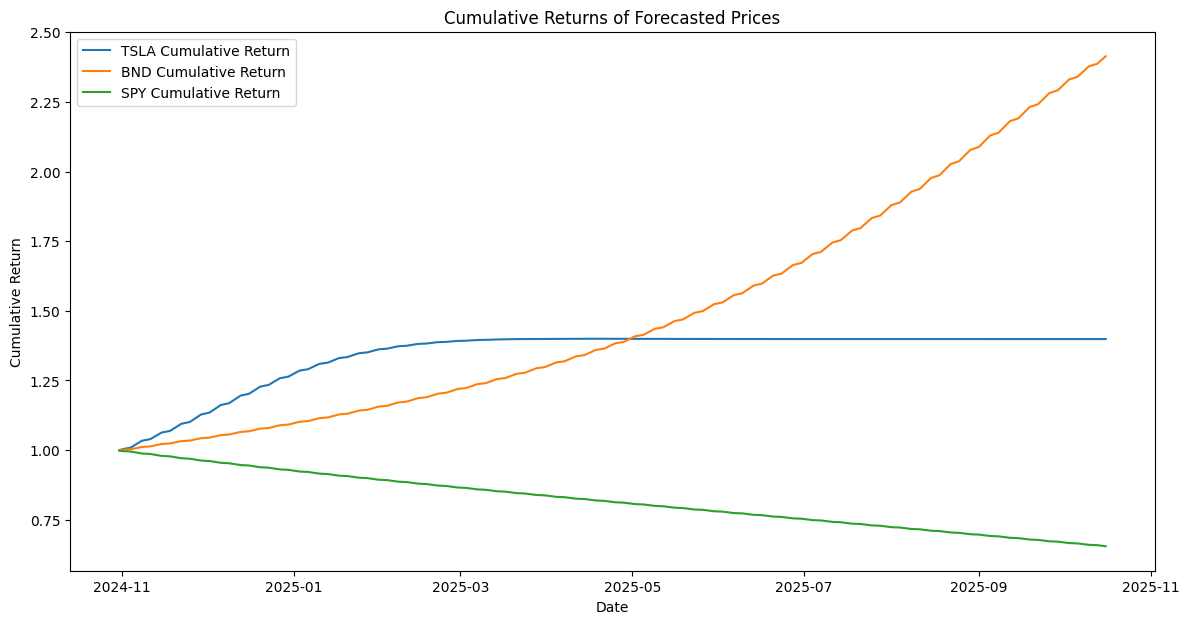

In [37]:
import matplotlib.pyplot as plt

# Calculate cumulative returns for the forecasted period
cumulative_returns = (1 + returns_df).cumprod()

# Plot cumulative returns for each asset
plt.figure(figsize=(14, 7))
for asset in cumulative_returns.columns:
    plt.plot(cumulative_returns.index, cumulative_returns[asset], label=f'{asset} Cumulative Return')

plt.title('Cumulative Returns of Forecasted Prices')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()
